<a href="https://colab.research.google.com/github/djdongjin/IFT6135-Assignment/blob/master/A13_submitted_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3

**Team member** (alphabetical order): Jin Dong, Liheng Ma, Maximilien Le Clei.

Github Link: https://github.com/djdongjin/IFT6135-Assignment.

## Environment Setting and Data Preprocessing

To reproduce the result, please put the dataset into a folder of google drive whose path is saved in *data_path*,  in our case, data_path = '/content/gdrive/My\ Drive/Datasets/dogcat'

In [0]:
! nvidia-smi
! pip install mxnet-cu100

Thu Feb 14 01:11:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    57W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import mxnet as mx
from mxnet import autograd, nd, init, gluon
from mxnet.gluon import nn, loss as gloss, data as gdata

import os
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile

We load the dataset and move files into the virtual machine environment of colab
 to speed up image loading.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

data_path = '/content/gdrive/My\ Drive/Datasets/dogcat'
base_path = '/content/dogcat'

! rm -rf '/content/dogcat'
! cp -r $data_path /content

for f in ['trainset.zip', 'testset.zip']:
    with zipfile.ZipFile(os.path.join(base_path, f)) as z:
        z.extractall(base_path)
        
! rm -rf /content/dogcat/__MACOSX
! ls /content/dogcat

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
sample_submission.csv  submission.csv  testset.zip  trainset.zip
state_dict.pickle      testset	       trainset


We divided the dataset into four folders:

- trainset: the original training dataset which will be used to re-train the final model after parameter tuning.
- testset: the original test dataset used to generate predictions.
- train, valid: the training dataset and validation dataset used to train and select hyperparameters. They are splitted from trainset as a split ratio.

In [0]:
train_valid_path = 'trainset'
test_path = 'testset'
train_path = 'train'
valid_path = 'valid'


def delete_dir(path):
    if os.path.exists(os.path.join(*path)):
        shutil.rmtree(os.path.join(*path))
        
def create_dir(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

def devide_train_valid(base_path, train_valid_path, train_path, valid_path,
                       valid_ratio=0.2, labels=['Dog', 'Cat']):
    delete_dir([base_path, train_path])
    delete_dir([base_path, valid_path])
        
    all_files_by_label = [os.listdir(os.path.join(base_path, train_valid_path, label))
                          for label in labels]
    
    count_train = {label:0 for label in labels}
    count_valid = {label:0 for label in labels}
    
    for label, file_per_label in zip(labels, all_files_by_label):
        print('Train&Valid set, %s: %s' % (label, len(file_per_label)))
        create_dir([base_path, train_path, label])
        create_dir([base_path, valid_path, label])
        for f in file_per_label:
            if count_train[label] < len(file_per_label) * (1 - valid_ratio):
                shutil.copy(os.path.join(base_path, train_valid_path, label, f),
                            os.path.join(base_path, train_path, label, f))
                count_train[label] += 1
            else:
                shutil.copy(os.path.join(base_path, train_valid_path, label, f),
                            os.path.join(base_path, valid_path, label, f))
                count_valid[label] += 1
        print('Train set, %s: %s' % (label, count_train[label]))
        print('Valid set, %s: %s' % (label, count_valid[label]))
                
devide_train_valid(base_path, train_valid_path, train_path, valid_path)

Train&Valid set, Dog: 9999
Train set, Dog: 8000
Valid set, Dog: 1999
Train&Valid set, Cat: 9999
Train set, Cat: 8000
Valid set, Cat: 1999


We defined four data iterators as below, given a batch size. We also have different data augmentation pipelines for train dataset and test dataset, since test dataset should keep unchanged.

In [0]:
train_data = gdata.vision.ImageFolderDataset(
    os.path.join(base_path, train_path), flag=1)
valid_data = gdata.vision.ImageFolderDataset(
    os.path.join(base_path, valid_path), flag=1)
train_valid_data = gdata.vision.ImageFolderDataset(
    os.path.join(base_path, train_valid_path), flag=1)
test_data = gdata.vision.ImageFolderDataset(
    os.path.join(base_path, test_path), flag=1)

aug_train = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomResizedCrop(64, scale=(0.75, 1),
                                               ratio=(3.0/4.0, 4.0/3.0)),
        gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.RandomColorJitter(brightness=0.4, 
                                              contrast=0.4, saturation=0.4),
    gdata.vision.transforms.RandomLighting(0.1),
    gdata.vision.transforms.ToTensor(),
#     gdata.vision.transforms.Normalize([0.485, 0.456, 0.406], 
#                                       [0.229, 0.224, 0.225])
])

aug_test = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor(),
#     gdata.vision.transforms.Normalize([0.485, 0.456, 0.406], 
#                                       [0.229, 0.224, 0.225])
])
    
def load_data_iter(batch_size):

    train_iter = gdata.DataLoader(train_data.transform_first(aug_train), batch_size,
                                  shuffle=True, last_batch='keep')
    valid_iter = gdata.DataLoader(valid_data.transform_first(aug_test), batch_size,
                                  shuffle=False, last_batch='keep')
    train_valid_iter = gdata.DataLoader(train_valid_data.transform_first(aug_train), batch_size,
                                  shuffle=True, last_batch='keep')
    test_iter  = gdata.DataLoader(test_data.transform_first(aug_test), batch_size,
                                  shuffle=False, last_batch='keep')
    
    return train_iter, valid_iter, train_valid_iter, test_iter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Ignoring /content/dogcat/trainset/.DS_Store, which is not a directory.
  


## 1. Model Architecture

Our model is based on VGG-11 with some modifications, since it is designed for ImageNet with size of 224x224, but our data size is 64x64. We deleted the last vgg block because too many pooling layers are included which reduced the image size to 2x2. Instead, we add an extra convolutional layer in the second vgg blocks to maintain the number of convolutional layers.

The final archtecture and corresponding hyperparameters (e.g. kernel size, padding) we used is as below. It includes four vgg blocks, each of which has one or two convolutional layers followed by a MaxPooling layer. At the end, we added three dense layers to produce the final results.

The number of parameters is: $32*3*3 + 64*3*3*2 + 128*3*3*2 + 256*3*3*2 + 4097*1024 + 1025*512 + 513*2=4729506$.

We also tried using larger dense layers (2048, 1024 for each hidden layer), but didn't get improvements on validation performance.

In [0]:
# vgg11

Sequential(
  (0): VGGBlock(
    (net): Sequential(
      (0): Conv2D(3 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
  )
  (1): VGGBlock(
    (net): Sequential(
      (0): Conv2D(32 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
  )
  (2): VGGBlock(
    (net): Sequential(
      (0): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
  )
  (3): VGGBlock(
    (net): Sequential(
      (0): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(

### 1.1 Building VGG

In [0]:
# VGG modified
class VGGBlock(nn.Block):
    def __init__(self, num_conv, num_channel, **kwargs):
        super(VGGBlock, self).__init__(**kwargs)
        
        self.net = nn.Sequential()
        for i in range(num_conv):
            self.net.add(nn.Conv2D(num_channel, kernel_size=3, 
                              padding=1, activation='relu'))
        self.net.add(nn.MaxPool2D(pool_size=2, strides=2))
            
    def forward(self, X):
        return self.net(X)
    

def VGG(blocks):
    net = nn.Sequential()
    # Conv
    for num_conv, num_channel in blocks:
        net.add(VGGBlock(num_conv, num_channel))
    # Dense
    net.add(nn.Dense(1024, activation='relu'),
             nn.Dense(512, activation='relu'),
             nn.Dense(2))
    return net

### 1.2 Training and Evaluation

In [0]:
loss = gloss.SoftmaxCrossEntropyLoss()

def evaluate(net, test_iter, ctx):
    acc, ls, n = 0.0, 0.0, 0
    for X, y in test_iter:
        X, y = X.as_in_context(ctx), y.astype('float32').as_in_context(ctx)
        
        y_hat = net(X)
        ls  += loss(y_hat, y).sum().asscalar()
        acc += (y_hat.argmax(axis=1) == y).sum().asscalar()
        n   += y.size
    return acc / n, ls / n


def train(net, train_iter, valid_iter, num_epochs, batch_size, lr, ctx):
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    
    for i in range(1, num_epochs+1):
        
        train_acc, train_l, n, start = 0.0, 0.0, 0, time.time()
        # compute train loss
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.astype('float32').as_in_context(ctx)
            
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            
            l.backward()
            trainer.step(batch_size)
            train_l += l.asscalar()
            train_acc += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
            
        tm = time.time() - start
        print('epoch %s, train loss %.4f, train acc %.4f, time %.2f' % 
             (i, train_l/n, train_acc/n, tm))
        
        valid_acc, valid_l = evaluate(net, valid_iter, ctx)
        print('epoch %s, valid loss %.4f, valid acc %.4f.' % 
              (i, valid_l, valid_acc))
        
        train_loss.append(train_l/n)
        valid_loss.append(valid_l)
        train_accuracy.append(train_acc/n)
        valid_accuracy.append(valid_acc)
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy

In [0]:
def loss_acc_plot(content=["valid_acc","train_acc","valid_loss","train_loss"],
                  valid_acc=None,train_acc=None,valid_loss=None,train_loss=None,
                  fig_size=(15,15),
                  savefile='/content/gdrive/My Drive/Datasets/dogcat'+"p3_err_loss.jpg",
                  title="VGG"):
    """
    content: a list of string denotes 
    including 'valid_acc','train_acc','valid_loss','train_loss' 
    """
    plt.figure(figsize=fig_size)
    acc=0
    loss=0
    if "valid_acc" in content and valid_acc!=None:
        epochs=np.arange(np.array(valid_acc).reshape(-1).shape[0])+1
        plt.plot(epochs,valid_acc,"b-",label="validation_acc")
        acc=1
    if "train_acc" in content and train_acc!=None:
        epochs=np.arange(np.array(train_acc).reshape(-1).shape[0])+1
        plt.plot(epochs,train_acc,"g-",label="training_acc")
        acc=1
    if "valid_loss" in content and valid_loss!=None:
        epochs=np.arange(np.array(valid_loss).reshape(-1).shape[0])+1
        plt.plot(epochs,valid_loss,"b:",label="validation_loss")
        loss=1
    if "train_loss" in content and train_loss!=None:
        epochs=np.arange(np.array(train_loss).reshape(-1).shape[0])+1
        plt.plot(epochs,train_loss,"g:",label="training_loss")
        loss=1

    plt.xticks(epochs)
    plt.xlabel("training epochs",fontsize=18)
    if acc==1 and loss==1:
        plt.ylabel("acc/loss",fontsize=18)
    elif acc==0 and loss==1:
        plt.ylabel("loss",fontsize=18)
    elif acc==1 and loss==0:
        plt.ylabel("acc",fontsize=18)

    plt.title(title,fontsize=20)
    plt.legend(fontsize=15)
    plt.savefig(savefile)
    plt.show()

## 2. Experiments

**Dataset**

We split the original training set into a training set and a validation set with a ratio of 0.8. Meanwhile, we used several data augmentation techniques to expand the dataset, including: 

- Random crop the image and resize to the original size: RandomResizedCrop.
- Random flip left or right the image: RandomFlipLeftRight.
- Random change the color properties of the image: RandomColorJitter, RandomLighting.

We also tried to normalize the image but the performance didn't change too much. We also only did augmentation on training set to ensure the validation accuracy is sound.


**Results**

We finally achieved **0.8682** accuracy on training set and **0.8464** accuracy on validation set, with hyperparameter setting mentioned below. After retraining, the highest score we achieved on Kaggle is **88%**.

We plot the accuracy (1-error) and loss curves  on training set and validation set. We found that the learning speed is slow. Compared with SGD, a more powerful optimizier, such as Adam, should be helpful and faster to converge to a minimum point.

BatchNorm should be helpful to improve the validation performance, since it can be seen as a normalization over dataset and can let the model learn more steady.

A more advanced architecture with more normalization techniques is also helpful. For example, we did experiments on ResNet. Without BatchNorm, its performance is bad. But after adding BatchNorm, it's performance on validation set exceeded our model, achieved 91%. (Since we didn't implemented BatchNorm by hand, we didn't use this model for any submission. Details can be found in appendix.)

Dropout should not be very helpful because from the curve we can see that the model is not overfitted, which is the main issue that Dropout aims to solve.

After tuning hyperparameters, we retrained the model useing the whole training set and generated several submissions. The model could achieve **93%** accuracy on validation set whereas on the test set, it only achieved **88%**. The reason is that when retraining, the model has more data so that its accuracy becomes higher (also, the validation set is also included in the training set when retraining). But the test set is new and never be seen by the model, so that the accuracy becomes lower again.

### Generating Results

The hyperparameter setting we used for submission is as below:

- Epochs: 35
- Batch size: 128
- Learning rate: 0.1
- Model architecture: (1, 32), (2, 64), (2, 128), (2, 256), 1024, 512, 2. ((i, j) means a vgg block where i is denoted as number of convolutional layers and j is denoted as number of channels; the last three layers are dense layers.)

In [0]:
# conv_arch = ((1, 32), (1, 64), (2, 128), (2, 256), (2, 256))
ctx = mx.gpu()
num_epochs, batch_size = 35, 128
lr = 0.1
train_iter, valid_iter, train_valid_iter, test_iter = load_data_iter(batch_size)
conv_arch = ((1, 32), (2, 64), (2, 128), (2, 256))
vgg11 = VGG(conv_arch)
vgg11.initialize(init=init.Xavier(), ctx=ctx)
train_loss, valid_loss, train_accuracy, valid_accuracy = \
    train(vgg11, train_iter, valid_iter, num_epochs, batch_size, lr, ctx)

epoch 1, train loss 0.6922, train acc 0.5153, time 20.82
epoch 1, valid loss 0.6926, valid acc 0.5000.
epoch 2, train loss 0.6899, train acc 0.5394, time 17.65
epoch 2, valid loss 0.6848, valid acc 0.5550.
epoch 3, train loss 0.6827, train acc 0.5602, time 17.67
epoch 3, valid loss 0.6722, valid acc 0.5963.
epoch 4, train loss 0.6779, train acc 0.5729, time 18.70
epoch 4, valid loss 0.6609, valid acc 0.6051.
epoch 5, train loss 0.6685, train acc 0.5920, time 19.34
epoch 5, valid loss 0.6635, valid acc 0.5955.
epoch 6, train loss 0.6558, train acc 0.6116, time 20.60
epoch 6, valid loss 0.6520, valid acc 0.6256.
epoch 7, train loss 0.6457, train acc 0.6291, time 20.77
epoch 7, valid loss 0.6774, valid acc 0.5818.
epoch 8, train loss 0.6313, train acc 0.6455, time 19.64
epoch 8, valid loss 0.6221, valid acc 0.6588.
epoch 9, train loss 0.6174, train acc 0.6579, time 19.71
epoch 9, valid loss 0.6050, valid acc 0.6641.
epoch 10, train loss 0.6045, train acc 0.6723, time 20.80
epoch 10, valid

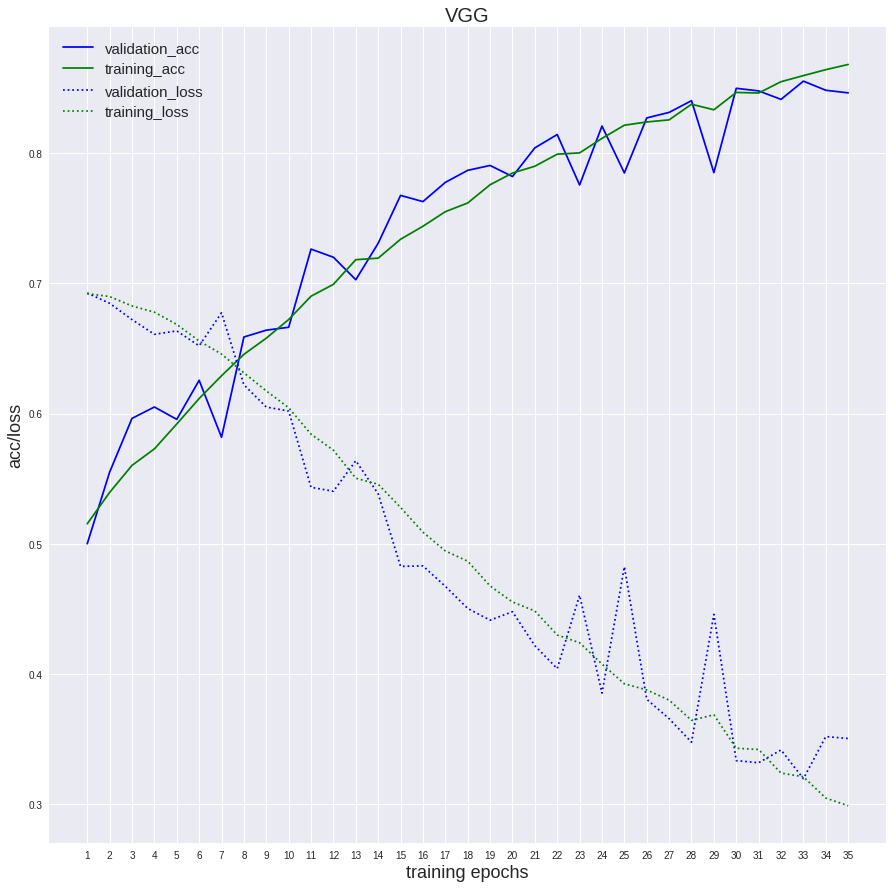

In [0]:
loss_acc_plot(content=["valid_acc","train_acc","valid_loss","train_loss"], 
              valid_loss=valid_loss, train_loss=train_loss, 
              valid_acc=valid_accuracy,train_acc=train_accuracy)

In [0]:
def pred_result(net, test_iter, ctx, write_path):
    res = []
    for X, y in test_iter:
        X = X.as_in_context(ctx)
        y_hat = net(X)
        pred  = y_hat.argmax(axis=1).astype('int').asnumpy()
        res.extend(pred)
        
    ids = [x for x in list(range(1, 1+len(test_data)))]
    ids.sort(key=lambda x: str(x))
    res = [train_valid_data.synsets[x] for x in res]
    
    res_df = pd.DataFrame({'id':ids, 'label':res})
    res_df.to_csv(os.path.join(write_path, 'submission.csv'), index=False)
    print('submission file has been saved in:', os.path.join(write_path, 'submission.csv'))
    
vgg11 = VGG(conv_arch)
vgg11.initialize(init=init.Xavier(), ctx=ctx)
train_loss, valid_loss, train_accuracy, valid_accuracy = \
    train(vgg11, train_valid_iter, valid_iter, num_epochs, batch_size, lr, ctx)
pred_result(vgg11, test_iter, ctx, '/content/gdrive/My Drive/Datasets/dogcat')

epoch 1, train loss 0.6915, train acc 0.5263, time 26.17
epoch 1, valid loss 0.6881, valid acc 0.5305.
epoch 2, train loss 0.6871, train acc 0.5477, time 25.90
epoch 2, valid loss 0.6766, valid acc 0.5865.
epoch 3, train loss 0.6789, train acc 0.5726, time 26.02
epoch 3, valid loss 0.6572, valid acc 0.6258.
epoch 4, train loss 0.6690, train acc 0.5947, time 25.97
epoch 4, valid loss 0.6427, valid acc 0.6316.
epoch 5, train loss 0.6491, train acc 0.6262, time 25.88
epoch 5, valid loss 0.6201, valid acc 0.6576.
epoch 6, train loss 0.6322, train acc 0.6459, time 26.00
epoch 6, valid loss 0.5904, valid acc 0.6818.
epoch 7, train loss 0.6089, train acc 0.6677, time 25.24
epoch 7, valid loss 0.5602, valid acc 0.7171.
epoch 8, train loss 0.5875, train acc 0.6853, time 25.90
epoch 8, valid loss 0.5439, valid acc 0.7221.
epoch 9, train loss 0.5626, train acc 0.7071, time 25.82
epoch 9, valid loss 0.5192, valid acc 0.7524.
epoch 10, train loss 0.5435, train acc 0.7191, time 26.09
epoch 10, valid

### Hyperparameter Tuning

All of settings are based on the setting used for generating results and only the corresponding hyperparameter is different:

- Batch size: (128, 256), validation accuracy: (0.8464, 0.7571)
- Learning rate: (0.1, 0.05, 0.005), validation accuracy: (0.8464, 0.8304, 0.6393)
- Epochs: (15, 25, 35), validation accuracy: (0.7676, 0.7849, 0.8464)




In [0]:
# batch_size: 256
num_epochs, batch_size = 35, 256
lr = 0.1
train_iter, valid_iter, train_valid_iter, test_iter = load_data_iter(batch_size)
conv_arch = ((1, 32), (2, 64), (2, 128), (2, 256))
vgg12 = VGG(conv_arch)
vgg12.initialize(init=init.Xavier(), ctx=ctx)
train_loss, valid_loss, train_accuracy, valid_accuracy = \
    train(vgg12, train_iter, valid_iter, num_epochs, batch_size, lr, ctx)

epoch 1, train loss 0.6928, train acc 0.5124, time 17.13
epoch 1, valid loss 0.6919, valid acc 0.5008.
epoch 2, train loss 0.6916, train acc 0.5363, time 17.10
epoch 2, valid loss 0.6904, valid acc 0.5923.
epoch 3, train loss 0.6907, train acc 0.5414, time 17.14
epoch 3, valid loss 0.6883, valid acc 0.5843.
epoch 4, train loss 0.6882, train acc 0.5569, time 17.10
epoch 4, valid loss 0.6844, valid acc 0.5868.
epoch 5, train loss 0.6868, train acc 0.5464, time 17.15
epoch 5, valid loss 0.6802, valid acc 0.5885.
epoch 6, train loss 0.6854, train acc 0.5597, time 17.09
epoch 6, valid loss 0.6789, valid acc 0.5713.
epoch 7, train loss 0.6819, train acc 0.5687, time 17.10
epoch 7, valid loss 0.6762, valid acc 0.5770.
epoch 8, train loss 0.6823, train acc 0.5629, time 17.09
epoch 8, valid loss 0.6796, valid acc 0.6086.
epoch 9, train loss 0.6763, train acc 0.5820, time 17.09
epoch 9, valid loss 0.6657, valid acc 0.6046.
epoch 10, train loss 0.6744, train acc 0.5871, time 17.12
epoch 10, valid

In [0]:
# lr: 0.05
num_epochs, batch_size = 35, 128
lr = 0.05
train_iter, valid_iter, train_valid_iter, test_iter = load_data_iter(batch_size)
conv_arch = ((1, 32), (2, 64), (2, 128), (2, 256))
vgg12 = VGG(conv_arch)
vgg12.initialize(init=init.Xavier(), ctx=ctx)
train_loss, valid_loss, train_accuracy, valid_accuracy = \
    train(vgg12, train_iter, valid_iter, num_epochs, batch_size, lr, ctx)

epoch 1, train loss 0.6919, train acc 0.5199, time 17.69
epoch 1, valid loss 0.6906, valid acc 0.5698.
epoch 2, train loss 0.6901, train acc 0.5356, time 17.66
epoch 2, valid loss 0.6885, valid acc 0.5353.
epoch 3, train loss 0.6878, train acc 0.5440, time 18.28
epoch 3, valid loss 0.6816, valid acc 0.5858.
epoch 4, train loss 0.6841, train acc 0.5584, time 19.37
epoch 4, valid loss 0.6817, valid acc 0.5488.
epoch 5, train loss 0.6795, train acc 0.5759, time 20.64
epoch 5, valid loss 0.6664, valid acc 0.6111.
epoch 6, train loss 0.6746, train acc 0.5876, time 20.57
epoch 6, valid loss 0.6703, valid acc 0.5820.
epoch 7, train loss 0.6658, train acc 0.6007, time 20.56
epoch 7, valid loss 0.7264, valid acc 0.5183.
epoch 8, train loss 0.6598, train acc 0.6103, time 20.38
epoch 8, valid loss 0.6560, valid acc 0.6096.
epoch 9, train loss 0.6489, train acc 0.6268, time 20.62
epoch 9, valid loss 0.6568, valid acc 0.6108.
epoch 10, train loss 0.6380, train acc 0.6441, time 19.20
epoch 10, valid

In [0]:
# lr: 0.005
num_epochs, batch_size = 35, 128
lr = 0.005
train_iter, valid_iter, train_valid_iter, test_iter = load_data_iter(batch_size)
conv_arch = ((1, 32), (2, 64), (2, 128), (2, 256))
vgg12 = VGG(conv_arch)
vgg12.initialize(init=init.Xavier(), ctx=ctx)
train_loss, valid_loss, train_accuracy, valid_accuracy = \
    train(vgg12, train_iter, valid_iter, num_epochs, batch_size, lr, ctx)

epoch 1, train loss 0.6930, train acc 0.5175, time 19.46
epoch 1, valid loss 0.6926, valid acc 0.5573.
epoch 2, train loss 0.6924, train acc 0.5364, time 20.23
epoch 2, valid loss 0.6922, valid acc 0.5145.
epoch 3, train loss 0.6921, train acc 0.5377, time 21.13
epoch 3, valid loss 0.6918, valid acc 0.5620.
epoch 4, train loss 0.6918, train acc 0.5520, time 21.23
epoch 4, valid loss 0.6914, valid acc 0.5655.
epoch 5, train loss 0.6914, train acc 0.5658, time 19.77
epoch 5, valid loss 0.6909, valid acc 0.5738.
epoch 6, train loss 0.6909, train acc 0.5690, time 19.01
epoch 6, valid loss 0.6904, valid acc 0.5695.
epoch 7, train loss 0.6904, train acc 0.5622, time 19.13
epoch 7, valid loss 0.6899, valid acc 0.5763.
epoch 8, train loss 0.6900, train acc 0.5646, time 18.43
epoch 8, valid loss 0.6893, valid acc 0.5708.
epoch 9, train loss 0.6895, train acc 0.5661, time 19.23
epoch 9, valid loss 0.6886, valid acc 0.5713.
epoch 10, train loss 0.6888, train acc 0.5700, time 20.01
epoch 10, valid

In [0]:
# vgg11 is trained
# This code block is used to get info for visualization
# Visualization related code can be found in the github.
import numpy as np
train_iter, valid_iter, train_valid_iter, test_iter = load_data_iter(128)

state_dict = {}
y_hat_np, y_np, res = np.zeros((1, 2)), np.zeros((1)), np.zeros((1))
for X, y in valid_iter:
    X, y = X.as_in_context(ctx), y.asnumpy()
    y_hat = vgg11(X).softmax().asnumpy()
    pred = y_hat.argmax(axis=1) == y

    y_hat_np = np.concatenate((y_hat_np, y_hat), axis=0)
    y_np = np.concatenate((y_np, y), axis=0)
    res = np.concatenate((res, pred), axis=0)

y_hat_np, y_np, res = y_hat_np[1:, :], y_np[1:], res[1:]
y_res = np.concatenate((y_np.reshape((-1,1)), res.reshape((-1,1))), axis=1)

y_hat_np = y_hat_np.tolist()
y_res = y_res.tolist()
y_res = [(i, x, y) for i, (x, y) in enumerate(y_res) if y==0]

y_res = [(i, x, y_hat_np[i][int(x)]) for (i, x, y) in y_res]

err_0 = [(i, x, y) for (i, x, y) in y_res if x==0]
err_1 = [(i, x, y) for (i, x, y) in y_res if x==1]
err_0.sort(key=lambda t: t[2])
err_1.sort(key=lambda t: t[2])
print('Nuber of wrong classified',valid_data.synsets[0], ':', len(err_0))
print('Nuber of wrong classified',valid_data.synsets[1], ':', len(err_1))

least5_0 = [(x[0],x[2]) for x in err_0[:5]]
top5_0 = [(x[0],x[2]) for x in err_0[-5:]]
least5_1 = [(x[0],x[2]) for x in err_1[:5]]
top5_1 = [(x[0],x[2]) for x in err_1[-5:]]

filename = lambda y: [(valid_data.items[x[0]][0].split('/')[-1],x[1]) for x in y]

state_dict['least0'] = filename(least5_0)
state_dict['top0'] = filename(top5_0)
state_dict['least1'] = filename(least5_1)
state_dict['top1'] = filename(top5_1)

wt = [aa.data().asnumpy() 
      for aa in vgg11.collect_params('conv.*weight').values()]

state_dict['conv_first'] = wt[0]
state_dict['conv_last']  = wt[-1]

import pickle
with open('/content/gdrive/My Drive/Datasets/dogcat/state_dict.pickle', 'wb') as f:
    pickle.dump(state_dict, f)
with open('/content/gdrive/My Drive/Datasets/dogcat/state_dict.pickle', 'rb') as f:
    aaa = pickle.load(f)

Nuber of wrong classified Cat : 101
Nuber of wrong classified Dog : 178


## Appendix: ResNet Implementation

We also implemented and tested a ResNet on the dataset. With BatchNorm, it can achieve higher accuracy with less epochs. But when BatchNorm is dropped out, its accuracy is pretty low. Considering that BatchNorm need to be implemented by hand, we only used this part as an experiment and didn't use it to submit results on kaggle.

In [0]:
class ResBlock(nn.Block):
    def __init__(self, n_channels, strides=1, nin=False, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        
        self.conv1 = nn.Conv2D(n_channels, kernel_size=3, padding=1, strides=strides)
        self.conv2 = nn.Conv2D(n_channels, kernel_size=3, padding=1)
        
        self.nin   = None
        if nin:
            self.nin = nn.Conv2D(n_channels, kernel_size=1, strides=strides)
            
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()
            
    def forward(self, X):
        res = nd.relu(self.bn1(self.conv1(X)))
        res = self.bn2(self.conv2(res))
        
        if self.nin:
            X = self.nin(X)
        return nd.relu(res + X)

In [0]:
class ResNet18(nn.Block):
    
    def __init__(self, n_outputs, **kwargs):
        super(ResNet18, self).__init__(**kwargs)
        
        self.net = nn.Sequential()
        self.net.add(
            nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(),
            nn.Activation('relu')
        )
        
        self.net.add(
            self.add_block(64, 2, nin=True),
            self.add_block(128, 2),
            self.add_block(256, 2),
            self.add_block(512, 2)
        )
        
        self.net.add(nn.GlobalAvgPool2D(), nn.Dense(n_outputs))
        
    def forward(self, X):
        return self.net(X)
        
    def add_block(self, n_channels, n_blocks, nin=False):
        net = nn.Sequential()

        if not nin:
            net.add(ResBlock(n_channels, 2, True))
            n_blocks -= 1

        for i in range(n_blocks):
            net.add(ResBlock(n_channels))

        return net

In [0]:
resnet = ResNet18(2)
resnet.initialize(init=init.Xavier(), force_reinit=True, ctx=ctx)
num_epochs, batch_size = 35, 128
lr = 5e-2
ctx = mx.gpu()
train(resnet, train_iter, valid_iter, num_epochs, batch_size, lr, ctx)

epoch 1, train loss 0.9074, train acc 0.5543, time 97.63
epoch 1, test acc 0.5458.
epoch 2, train loss 0.6675, train acc 0.6156, time 97.46
epoch 2, test acc 0.6496.
epoch 3, train loss 0.6459, train acc 0.6331, time 97.36
epoch 3, test acc 0.5128.
epoch 4, train loss 0.6149, train acc 0.6719, time 97.23
epoch 4, test acc 0.6738.
epoch 5, train loss 0.5932, train acc 0.6843, time 97.23
epoch 5, test acc 0.7404.
epoch 6, train loss 0.5673, train acc 0.7096, time 97.54
epoch 6, test acc 0.7071.
epoch 7, train loss 0.5462, train acc 0.7221, time 97.28
epoch 7, test acc 0.5630.
epoch 8, train loss 0.5244, train acc 0.7425, time 97.36
epoch 8, test acc 0.7449.
epoch 9, train loss 0.4928, train acc 0.7650, time 97.67
epoch 9, test acc 0.7224.
epoch 10, train loss 0.4694, train acc 0.7756, time 97.37
epoch 10, test acc 0.6308.
epoch 11, train loss 0.4428, train acc 0.7924, time 97.41
epoch 11, test acc 0.7759.
epoch 12, train loss 0.4149, train acc 0.8088, time 97.21
epoch 12, test acc 0.6983